<a href="https://colab.research.google.com/github/DinneRatj/Vector-Embedding-Model/blob/main/Softmax_1st_Run_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imporing libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

np.random.seed(1234)
torch.manual_seed(1234)

In [27]:
#Mounting to Gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#Reading data
learn_data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/bigml_59c28831336c6604c800002a.csv")
pd.options.display.max_columns = None
learn_data

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [39]:
#Defining columns
numerical_columns = ['number vmail messages', 'total day minutes', 'total day calls',
                     'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes',
                     'total night calls', 'total night charge', 'total intl minutes', 'total intl calls',
                     'total intl charge', 'customer service calls']
categorical_columns = ['state', 'international plan', 'voice mail plan','area code']
outputs = ['churn']

In [40]:
churn_data = learn_data[learn_data['churn'] == 'True']
notchurn_data = learn_data[learn_data['churn'] == 'False']

In [41]:
#Processing columns

#Numerical
numerical_data = np.stack([learn_data[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

#Categorical
for category in categorical_columns:
    learn_data[category] = learn_data[category].astype('category')
    
st = learn_data['state'].cat.codes.values
ip = learn_data['international plan'].cat.codes.values
vm = learn_data['voice mail plan'].cat.codes.values
ac = learn_data['area code'].cat.codes.values

categorical_data = np.stack([st, ip, vm, ac], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
learn_data[outputs] = learn_data[outputs].astype(int)

outputs = torch.tensor(learn_data[outputs].values).flatten()
outputs = outputs.long()

#print Outputs
print(numerical_data)
print(numerical_data.dtype)
print(numerical_data.shape)
print('_' * 75)

print(categorical_data)
print(categorical_data.dtype)
print(categorical_data.shape)
print('_' * 75)

tensor([[ 25.0000, 265.1000, 110.0000,  ...,   3.0000,   2.7000,   1.0000],
        [ 26.0000, 161.6000, 123.0000,  ...,   3.0000,   3.7000,   1.0000],
        [  0.0000, 243.4000, 114.0000,  ...,   5.0000,   3.2900,   0.0000],
        ...,
        [  0.0000, 180.8000, 109.0000,  ...,   6.0000,   3.8100,   2.0000],
        [  0.0000, 213.8000, 105.0000,  ...,  10.0000,   1.3500,   2.0000],
        [ 25.0000, 234.4000, 113.0000,  ...,   4.0000,   3.7000,   0.0000]])
torch.float32
torch.Size([3333, 14])
___________________________________________________________________________
tensor([[16,  0,  1,  1],
        [35,  0,  1,  1],
        [31,  0,  0,  1],
        ...,
        [39,  0,  0,  2],
        [ 6,  1,  0,  2],
        [42,  0,  1,  1]])
torch.int64
torch.Size([3333, 4])
___________________________________________________________________________


In [42]:
#Dividing the data
total_records = 3333
train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)
numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]
categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]
train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

#print divide dataset
print(train_records)
print(valid_records)
print(test_records)

1999
666
666


In [43]:
from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(15, 100)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(100)
        self.weights1 = Parameter(torch.Tensor(1, 120))
        init.kaiming_uniform_(self.weights1, a=math.sqrt(5))
        
        self.weights2 = Parameter(torch.Tensor(1, 120))
        init.kaiming_uniform_(self.weights2, a=math.sqrt(5))
        
        self.bias1 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights1)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias1, -bound, bound)
        
        self.bias2 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights2)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias2, -bound, bound)
        
        self.layer1_1 = nn.Embedding(51, 5)
        self.bn1_1 = nn.BatchNorm1d(5)
        self.layer1_2 = nn.Embedding(2, 5)
        self.bn1_2 = nn.BatchNorm1d(5)
        self.layer1_3 = nn.Embedding(2, 5)
        self.bn1_3 = nn.BatchNorm1d(5)
        
        self.layer2 = nn.Linear(120, 120)
        self.bn2 = nn.BatchNorm1d(120)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        x1 = self.relu(x1)
        x1 = self.bn1(x1)
        
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x1_embedding = self.relu(x1_embedding)
        x1_embedding = self.bn1_1(x1_embedding)
        
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x2_embedding = self.relu(x2_embedding)
        x2_embedding = self.bn1_2(x2_embedding)
        
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x3_embedding = self.relu(x3_embedding)
        x3_embedding = self.bn1_3(x3_embedding)
        
        x4_embedding = self.layer1_4(x_categorical[:,3])
        x4_embedding = self.relu(x4_embedding)
        x4_embedding = self.bn1_4(x4_embedding)
        
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding,x4_embedding], 1)
                
        x1 = torch.cat([x1, x_embedding], 1)
        
        x2 = self.layer2(x1)        
        emb = self.relu(x2)
        x2 = self.bn2(emb)
        
        
        x2_weights1 = torch.mm(x2, self.weights1.t()) + self.bias1
        x2_weights2 = torch.mm(x2, self.weights2.t()) + self.bias2
        
        x3 = torch.cat([x2_weights1, x2_weights2], 1)
        
                
        return emb, self.weights1, self.weights2, x3

In [44]:
model = Model()

In [45]:
#===============================================================================================
# Defining churn:loyal weight ratio. churn_percentage=0.7 means churn:loyal weight ratio of 7:3.
# Setting churn_percentage=0.5 to get an unweighted model
#===============================================================================================
churn_percentage = 0.7

#Defining loss function
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))
# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#29 Juni 2020: menambahkan scheduler learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

In [2]:
#Training the data
epochs = 100 
batch_size = 10
mean_losses_train = []
mean_losses_valid = []
best_loss_valid = np.inf

for i in range(epochs):
    model.train()
    aggregated_losses_train = []
    aggregated_losses_valid = []
    i += 1
    idxs = np.random.permutation(train_records)
    for j in range((train_records//batch_size)+1):
        start_train = j*batch_size
        end_train = start_train+batch_size
        
        idxs_batch = idxs[start_train:end_train]
        
        train, weights1, weights2, train_embed = model(numerical_train_data[idxs_batch], categorical_train_data[idxs_batch])
        train_loss = loss_function(train_embed, train_outputs[idxs_batch])
        aggregated_losses_train.append(train_loss)

        print(f'iteration: {j:3} loss: {train_loss.item():10.8f}')

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        mean_loss_train = torch.mean(torch.stack(aggregated_losses_train))
        
    print(f'epoch: {i:3} mean loss training: {mean_loss_train.item():10.8f}')
    mean_losses_train.append(mean_loss_train)
    
    model.eval()
    with torch.set_grad_enabled(False):
        for k in range((valid_records//batch_size)+1):
            start_valid = k*batch_size
            end_valid = start_valid+batch_size
            valid, weights1, weights2, valid_embed = model(numerical_valid_data[start_valid:end_valid], categorical_valid_data[start_valid:end_valid])
            valid_loss = loss_function(valid_embed, valid_outputs[start_valid:end_valid])
            aggregated_losses_valid.append(valid_loss)
    mean_loss_valid = torch.mean(torch.stack(aggregated_losses_valid))
    print(f'epoch: {i:3} mean loss validation: {mean_loss_valid:.8f}')
    
    if mean_loss_valid.cpu().numpy()[()] < best_loss_valid:
        best_loss_valid = mean_loss_valid
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/model_train_softmax.pth".format(churn_percentage))
#        torch.save(model.state_dict(), "model_train_cre_{}.pth".format(churn_percentage))
        best_epoch = i        
    
    mean_losses_valid.append(mean_loss_valid)
    scheduler.step()

NameError: ignored

In [ ]:
#Load training model
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/model_train_softmax.pth".format(churn_percentage)))
#model.load_state_dict(torch.load("model_train_cre_{}.pth".format(churn_percentage)))

<All keys matched successfully>

In [ ]:
#Creating predictions
with torch.no_grad():
    valid, valid_weights1, valid_weights2, valid_embed = model(numerical_valid_data, categorical_valid_data)
    valid_loss = loss_function(valid_embed, valid_outputs)
    total_valid_loss = valid_loss
print(f'Loss: {total_valid_loss:.8f}')

Loss: 0.37264562


In [ ]:
# =========================================================================================================
# [26 Mei 2020]: 
# hasil utama yang dilihat adalah F1 Score, karena metrik akurasi misleading digunakan untuk data imbalance
# =========================================================================================================

from sklearn.metrics import f1_score

valid_val = np.argmax(valid_embed, axis=1)
print(confusion_matrix(valid_outputs, valid_val))
print(classification_report(valid_outputs, valid_val))
print("Accuracy: ", accuracy_score(valid_outputs, valid_val))
print("F1 Score: ", f1_score(valid_outputs, valid_val, average='macro'))

[[534  30]
 [ 37  65]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       564
           1       0.68      0.64      0.66       102

    accuracy                           0.90       666
   macro avg       0.81      0.79      0.80       666
weighted avg       0.90      0.90      0.90       666

Accuracy:  0.8993993993993994
F1 Score:  0.8004338200764776


In [ ]:
# function for smoothing the loss plot by using exponential moving average
# https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar
def smooth(scalars, weight):
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [ ]:
me_losses_train = []
for l in mean_losses_train:
  me_losses_train.append(l.detach().numpy())

print (me_losses_train)
print (mean_losses_valid)

[array(0.5745654, dtype=float32), array(0.48374107, dtype=float32), array(0.44088936, dtype=float32), array(0.43754894, dtype=float32), array(0.4130331, dtype=float32), array(0.40759835, dtype=float32), array(0.40815187, dtype=float32), array(0.38769943, dtype=float32), array(0.37688744, dtype=float32), array(0.3791349, dtype=float32), array(0.35784066, dtype=float32), array(0.35201564, dtype=float32), array(0.356834, dtype=float32), array(0.34760404, dtype=float32), array(0.33072788, dtype=float32), array(0.3367199, dtype=float32), array(0.33958843, dtype=float32), array(0.34131014, dtype=float32), array(0.32004747, dtype=float32), array(0.32495052, dtype=float32), array(0.3197446, dtype=float32), array(0.30236658, dtype=float32), array(0.3255809, dtype=float32), array(0.3196175, dtype=float32), array(0.3108623, dtype=float32), array(0.29849124, dtype=float32), array(0.31744176, dtype=float32), array(0.32017508, dtype=float32), array(0.31750944, dtype=float32), array(0.30560818, dtype

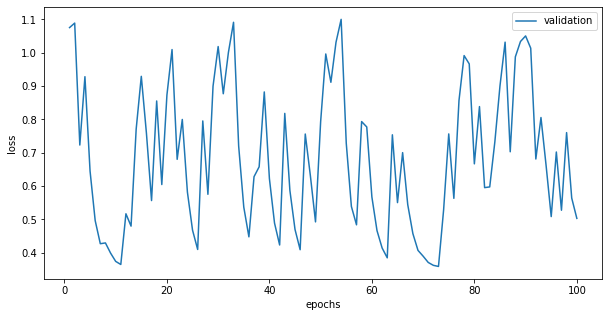

65


In [ ]:
epochs_to_show = 100
smoothing = 0.5
plt.figure(figsize=(10,5))
#plt.plot(range(1,epochs_to_show+1), smooth(me_losses_train[0:epochs_to_show],smoothing), label = 'train')
plt.plot(range(1,epochs_to_show+1), smooth(mean_losses_valid[0:epochs_to_show],smoothing), label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
# plt.ylim((0.0, 0.9))
# plt.title('loss graph')
plt.show()
print(best_epoch)